In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [3]:
df = pd.read_csv('../data/cleaned_gc_data/gc1.csv')

In [4]:
# Set 'time' as the index
df.set_index('secs', inplace= True)
df.head()

,power,hr,cad,session_time,hr_p_fatigue
secs,,,,,
0,95,96,80,0,72.25
1,99,97,83,1,72.25
2,125,96,86,2,64.75
3,191,96,90,3,48.25
4,230,97,90,4,39.50


In [5]:
df = df.drop(labels= ['session_time', 'hr_p_fatigue'], axis= 1)

In [6]:
df = df.rolling(5).mean();    # 5 sec rolling average
df.dropna(inplace= True)

In [7]:
# Scaling the data
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(df)

In [8]:
X = data_scaled
y = data_scaled[:,1] # hr is the target

In [9]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, shuffle= False, random_state = 42)

In [10]:
X_train.shape

(2024, 3)

In [11]:
X_test.shape

(675, 3)

In [12]:
y_train.shape

(2024,)

In [13]:
y_test.shape

(675,)

In [14]:
win_length = 60
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [15]:
train_generator[0][0].shape

(32, 60, 3)

In [16]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           67584     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 500,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/500
62/62 [==============================] - 2s 37ms/step - loss: 0.0187 - val_loss: 0.0146
Epoch 2/500
62/62 [==============================] - 1s 22ms/step - loss: 0.0114 - val_loss: 7.1902e-04
Epoch 3/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0146 - val_loss: 0.0022
Epoch 4/500
62/62 [==============================] - 1s 22ms/step - loss: 0.0158 - val_loss: 0.0017
Epoch 5/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0161 - val_loss: 7.1145e-04
Epoch 6/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0172 - val_loss: 7.9001e-04
Epoch 7/500
62/62 [==============================] - 1s 22ms/step - loss: 0.0157 - val_loss: 6.7834e-04
Epoch 8/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0164 - val_loss: 6.7955e-04
Epoch 9/500
62/62 [==============================] - 1s 21ms/step - loss: 0.0171 - val_loss: 7.3398e-04
Epoch 10/500
62/62 [==============================] - 1s 21ms/step - loss: 0

In [19]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [20]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9801787550262283, 0.8569802949510563)

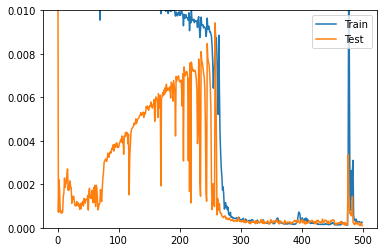

In [21]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .01);

In [22]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [23]:
hr_test_results_sc[1] = test_preds

In [24]:
hr_test_results_sc.head(10)

,0,1,2
0,0.874532,0.918896,0.844920
1,0.872035,0.919203,0.844920
2,0.837703,0.919868,0.839572
3,0.839576,0.921649,0.826203
4,0.848939,0.923986,0.828877
5,0.867665,0.926547,0.834225
6,0.889513,0.928219,0.850267
7,0.882022,0.928204,0.858289
8,0.861423,0.926319,0.855615
9,0.853308,0.923621,0.850267


In [25]:
# Column '1' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

,0,1,2
0,280.2,168.944123,98.0
1,279.4,168.968538,98.0
2,268.4,169.021521,97.6
3,269.0,169.163221,96.6
4,272.0,169.349306,96.8
5,278.0,169.553145,97.2
6,285.0,169.686201,98.4
7,282.6,169.685015,99.0
8,276.0,169.534955,98.8
9,273.4,169.320269,98.4


In [31]:
hr_test_results.shape[0]

615

In [32]:
# This is X_test, de-scaled (Original)
df[:][-hr_test_results.shape[0]:].reset_index()['hr'].head(10)

0    169.2
1    169.4
2    169.6
3    169.6
4    169.6
5    169.4
6    169.2
7    169.0
8    169.0
9    169.0
Name: hr, dtype: float64

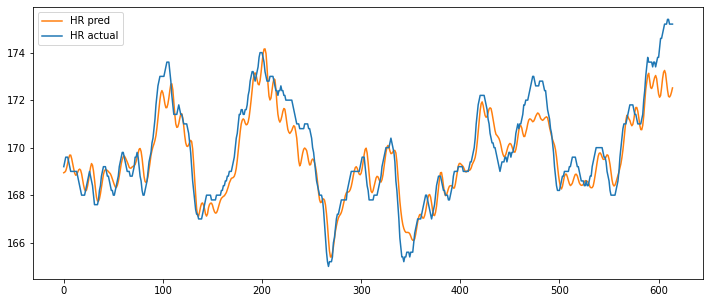

In [33]:
plt.figure(figsize= (12, 5))
plt.plot(hr_test_results[1], color = 'tab:orange', label= 'HR pred')
plt.plot(df[:][-hr_test_results.shape[0]:].reset_index()['hr'], color= 'tab:blue', label= 'HR actual')
#plt.plot(df[:][-507:].reset_index()['power'] * 0.5, color= 'tab:green', label= 'Power actual')
plt.legend();